### Importing libraries

In [70]:
import os
import numpy as np
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, wordnet, stopwords
from wordcloud import WordCloud
# Downloading the necessary corpora if not present
try:
    _ = nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')
try:
    _ = nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')
try:
    _ = nltk.data.find('corpora/words')
except:
    nltk.download('words')
try: 
    _ = nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt')
plt.style.use('ggplot') # Setting the style of plots

[nltk_data] Downloading package wordnet to /home/sriman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Collecting all the 100 post's comments into a single DF

In [71]:
files = os.listdir('data/')
df = pd.read_csv(os.path.join('data/', files[-1]))
files.pop()
for file in files:
    df =  pd.concat([df, pd.read_csv(os.path.join('data/', file))], axis=0)

In [72]:
print(f"Number of columns: {df.shape[1]} \nNumber of rows: {df.shape[0]}")

Number of columns: 6 
Number of rows: 36944


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36944 entries, 0 to 91
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment_id           36944 non-null  object 
 1   comment_parent_id    36944 non-null  object 
 2   comment_body         36944 non-null  object 
 3   comment_depth        36944 non-null  int64  
 4   comment_score        36944 non-null  int64  
 5   comment_created_utc  36944 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.0+ MB


### Deleted, removed, or repetitive comments.

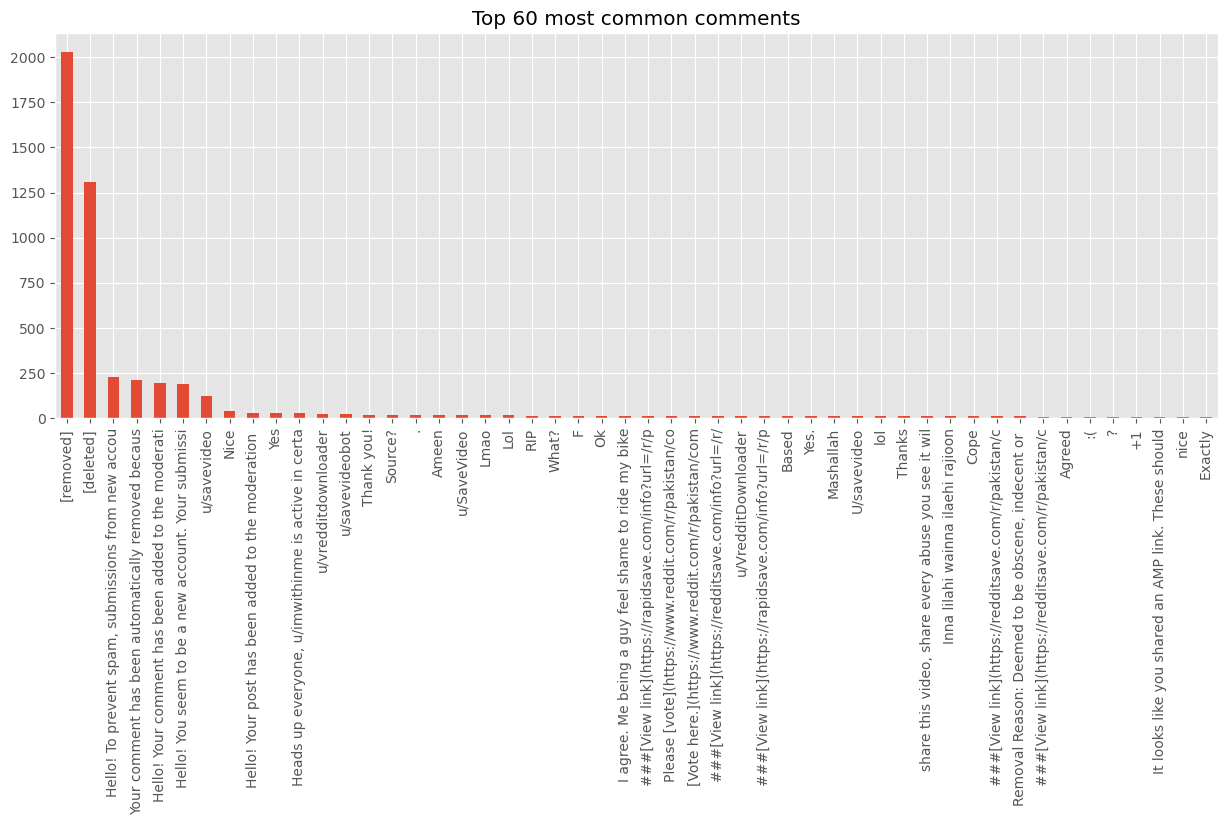

In [74]:
# Top 60 most common comments
X = df['comment_body'].value_counts().head(50)
# Trim the comments to 50 characters
X.index = X.index.str[:50]
# Plot the top 60 most common comments
X.plot(kind='bar', figsize=(15, 5), title='Top 60 most common comments')
plt.show()

The comments include messages like \[removed\], \[deleted\], removed by moderators. Such messages are not neccessary for the Analysis and can be removed.

/tmp/ipykernel_38143/4178225853.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  helper_useless_tags = df[df['comment_body'].str.contains(r'(^u\/|^r\/)\w+$', regex=True)]


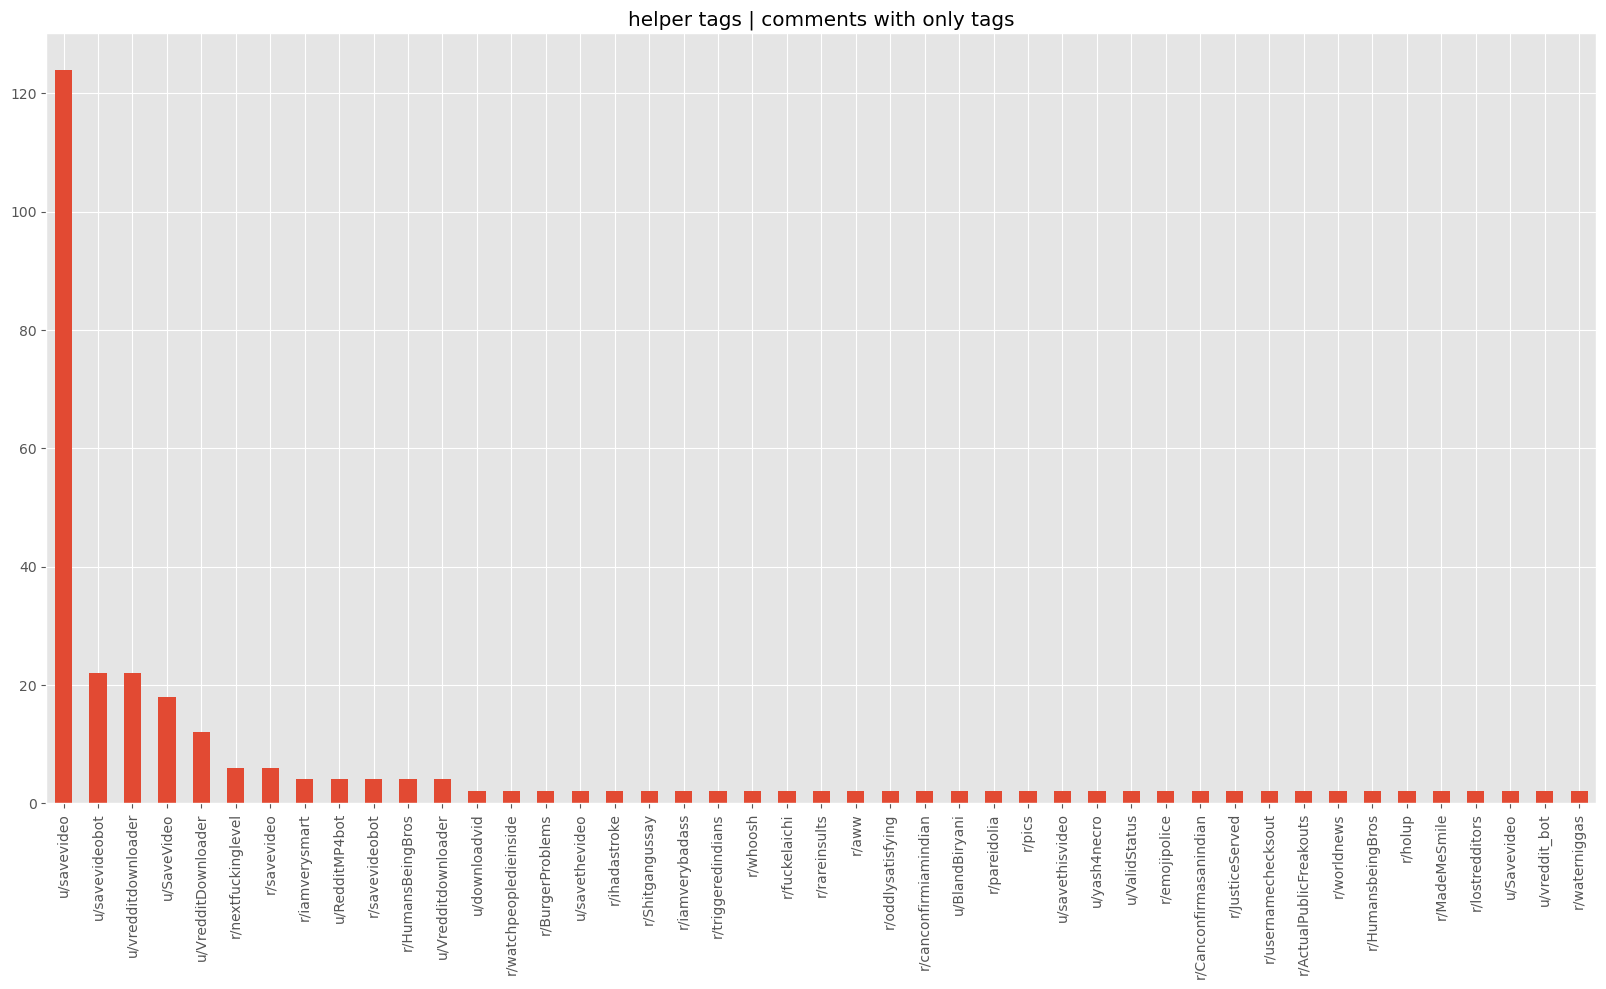

In [75]:
# Filter and display all messages that start with u/ or r/ in the comment_body and contain single word
helper_useless_tags = df[df['comment_body'].str.contains(r'(^u\/|^r\/)\w+$', regex=True)]
# generate a histogram of the number of comments per subreddit
helper_useless_tags['comment_body'].value_counts().plot(kind='bar', figsize=(20,10), title="helper tags | comments with only tags")
plt.show()

Some of the messages are just tags and do not contain any useful information. We will remove these messages from the dataset.

#### Removing the deleted and removed messages

In [76]:
X.head(10)

[removed]                                             2031
[deleted]                                             1311
Hello! To prevent spam, submissions from new accou     230
Your comment has been automatically removed becaus     210
Hello! Your comment has been added to the moderati     194
Hello! You seem to be a new account. Your submissi     190
u/savevideo                                            124
Nice                                                    40
Hello! Your post has been added to the moderation       30
Yes                                                     29
Name: comment_body, dtype: int64

In [77]:
# Removing the [Deleted] and [Removed] messages from the dataset 
df = df[df.comment_body != '[deleted]']
df = df[df.comment_body != '[removed]']
# Removing the comments with only tags or helper tags from the dataset
df = df[~df.comment_body.str.contains(r'(^u\/|^r\/)\w+$', regex=True)]
# Removing unnecessary messages(system messages) that contain certain subtext
df = df[~df.comment_body.str.contains("To prevent spam, submissions")]
df = df[~df.comment_body.str.contains("comment has been automatically removed")]
df = df[~df.comment_body.str.contains("has been added to the moderation")]
df = df[~df.comment_body.str.contains("Hello! You seem to be a new account")]

/tmp/ipykernel_38143/1717827089.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df.comment_body.str.contains(r'(^u\/|^r\/)\w+$', regex=True)]


### Comments containing emails and urls

In [78]:
# Stats about comments containing emails and urls
comment_has_email = df['comment_body'].str.contains(r'@[^\s]+')
comment_has_url = df['comment_body'].str.contains(r'((www\.[^\s]+)|(https?://[^\s]+))')

# Count the number of comments containing emails and urls
num_comments_with_email = comment_has_email.sum()
num_comments_with_url = comment_has_url.sum()
print('Number of comments containing emails: ', num_comments_with_email)
print('Number of comments containing urls: ', num_comments_with_url)

/tmp/ipykernel_38143/1071420812.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  comment_has_url = df['comment_body'].str.contains(r'((www\.[^\s]+)|(https?://[^\s]+))')


Number of comments containing emails:  24
Number of comments containing urls:  1155


#### Removing mails and urls from the comments

In [79]:
# Regex substitution:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_URLs(x))
df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_email(x))

### Sentence level analysis

#### Length-frequency analysis

Max length: 9025, Min length: 1, Average Length :  159.5584347233832


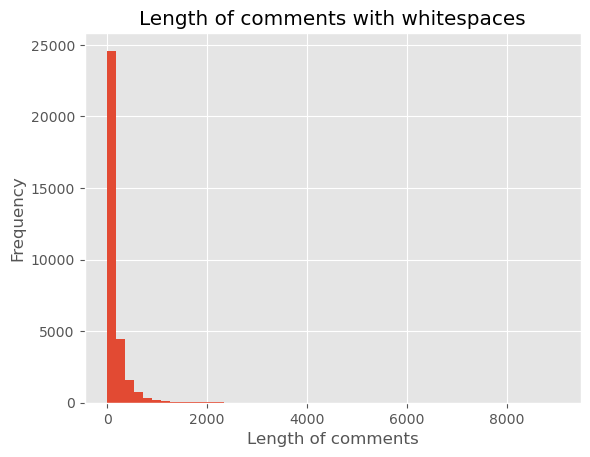

In [80]:
df['len']= df['comment_body'].str.len()
print(f"Max length: {np.max(df['len'])}, Min length: {np.min(df['len'])}, Average Length :  {np.mean(df['len'])}")
df['len'].hist(bins=50)
plt.title("Length of comments with whitespaces")
plt.xlabel("Length of comments")
plt.ylabel("Frequency")
plt.show()

Max length: 1548, Min length: 0, Average Length :  28.435094888703137


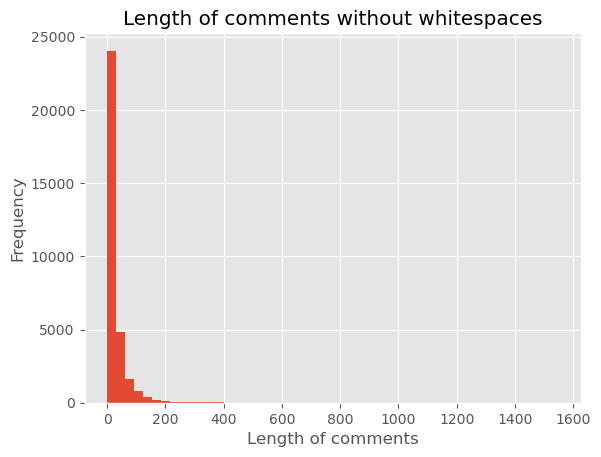

In [81]:
df['len']= df['comment_body'].str.split().map(lambda x: len(x))
print(f"Max length: {np.max(df['len'])}, Min length: {np.min(df['len'])}, Average Length :  {np.mean(df['len'])}")
df['len'].hist(bins=50)
plt.title("Length of comments without whitespaces")
plt.xlabel("Length of comments")
plt.ylabel("Frequency")
plt.show()

Though this histogram does not look different from the previous one, the average length and the maximum length of the comments have reduced. This indicates that the comments have a lot of space characters in them.
Some of the comments might only have space characters in them. Let's check for that.

In [82]:
print("number of comments having only space characters: ", df[df.comment_body.str.contains(r'^\s*$', regex=True)].shape[0])

number of comments having only space characters:  55


In [83]:
### removing sentences with only spaces
df = df[~df.comment_body.str.contains(r'^\s$', regex=True)]
df.shape

(32254, 7)

### Extract tokens from the comments corpus(+lowering)

In [84]:
tokens = []

def addToTokens(data: str):
    global tokens
    tokens += [word.lower() for word in word_tokenize(data)]
print(df['comment_body'])

# Apply to all comment_body(dont print)
_ = df['comment_body'].apply(addToTokens)

0     Good to see the boy bringing a plate and reduc...
1     When I was about 10 of 12, my aunt gave me a r...
2                                I wanna be a kid again
3     Is this not a cross post? Am sure the pics sub...
4                                         #noplastic 👏🏽
                            ...                        
85    They are what equalise the sensitive and burge...
86    Saying 65 64 quickly out loud in punjabi sound...
88    Haha I see. In Gujarati we would call them 'co...
90    Pindi is the Compton to Islamabad's Beverly Hi...
91                         I LiVe In BeVeRLy HilLs. Wow
Name: comment_body, Length: 32254, dtype: object


In [85]:
len(tokens)

1070847

### Word Level analysis

#### Word length - frequency

In [86]:
# Creating an dataframe for storing the word frequency and lenght
df_eda= pd.Series(tokens).value_counts().to_frame().reset_index()
df_eda.columns= ['word', 'count']
df_eda['word_len']= df_eda['word'].map(lambda x: len(x))
# Sort by word length
df_eda.sort_values(by= 'word_len', inplace= True)
df_eda.head()

,word,count,word_len
0,.,50662,1
21736,🏡,2,1
21763,🎁,2,1
12897,🗿,4,1
15899,😇,2,1


max length:  956
min length:  1
mean length:  7.057509309060819


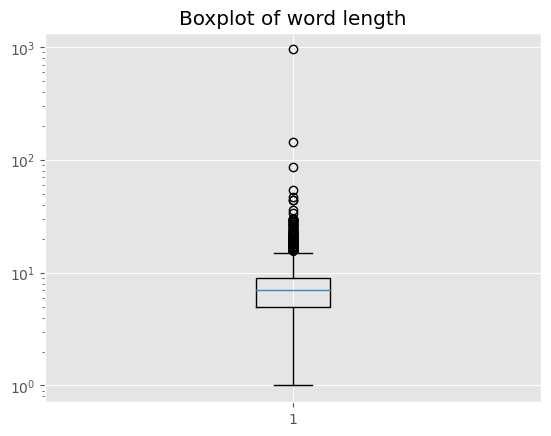

In [87]:
plt.boxplot(df_eda['word_len'])
plt.yscale('log')
print('max length: ', max(df_eda['word_len']))
print('min length: ', min(df_eda['word_len']))
print('mean length: ', np.mean(df_eda['word_len']))
plt.title("Boxplot of word length")
plt.show()

As we can see from the above boxplot, the maximum length of a word is 956 characters, indicating that some of the tokens(words) might just be random text typed by the user, which can be verified by looking at the large words.

In [88]:
df_eda.tail(10)

,word,count,word_len
16449,ahhahhahahhahhhhahhhhahhahahah,2,30
14974,us-citizen-living-here-for-35-year,2,34
18392,hahahhahahhahahgahahhahahahhahahhahw,2,36
16718,waja.😹😺😺👍👍👍☝🏻😨🥴😱😧😤😨😋😥🥵🤯🧐🤬😋🙁😚😋😗😀😗😍😇😂😉😙😁😋🤪😀🥰🙂😃,2,44
19332,............................................,2,44
23875,😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂,2,47
14585,biryaaaaaaaaaniiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...,2,54
14226,amp.dw.com/en/how-have-india-and-pakistan-fare...,2,87
14243,m.hindustantimes.com/india-news/india-at-70-a-...,2,145
18296,hahahahahahahahahahahahahahahahahahahahahahaha...,2,956


In [89]:
# filter out the words that are not in the wordnet corpus
df_eda = df_eda[df_eda['word'].isin(wordnet.words())]

In [90]:
df_eda.shape

(11029, 3)

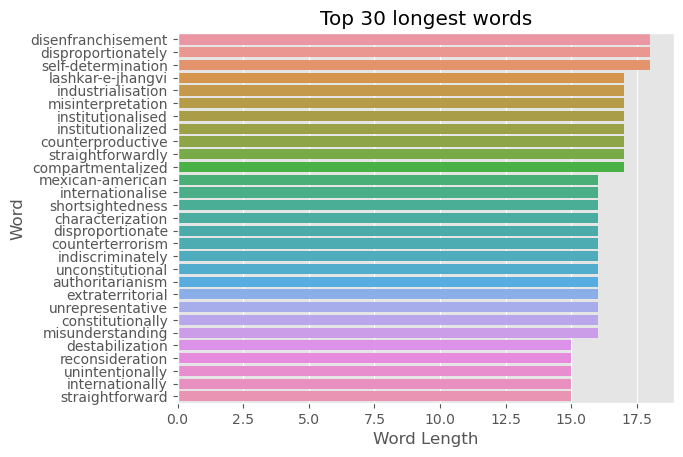

In [91]:
# Bar plot word length
sns.barplot(df_eda[-1:-30:-1], y='word', x='word_len')\
    .set(xlabel='Word Length', ylabel='Word', title='Top 30 longest words')
plt.show()

#### Frequencies of words with stopwords

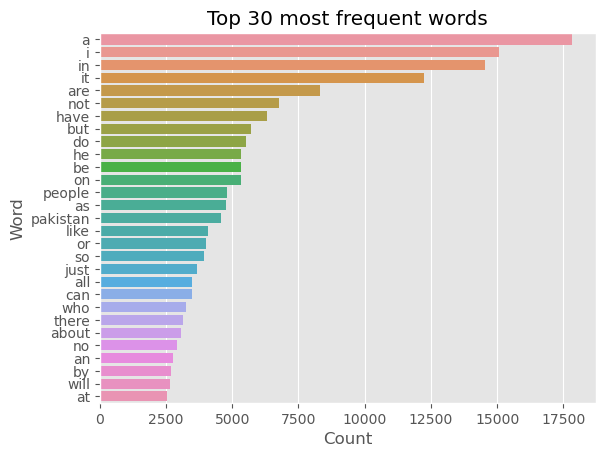

In [92]:
# Sort based on frequency of words
df_eda = df_eda.sort_values('count')
# Bar plot frequency of words 
sns.barplot(df_eda[-1:-30:-1], y='word', x='count').set(xlabel='Count', ylabel='Word', title='Top 30 most frequent words')
plt.show()

There are many words(*stopwords*) that are frequent, but are a part of the grammar and do not contribute to importance of the message. These words can be removed as well.

#### Removal of stopwords

In [93]:
# removing words less than 3 characters and stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df_eda['word'] = df_eda['word'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2 and w not in stop_words]))

# remove empty words with white spaces
df_eda = df_eda[df_eda['word'].apply(lambda x: len(x.strip())>0)]

In [94]:
df_eda.shape

(10696, 3)

#### Barplot of word frequencies without Lemmatization

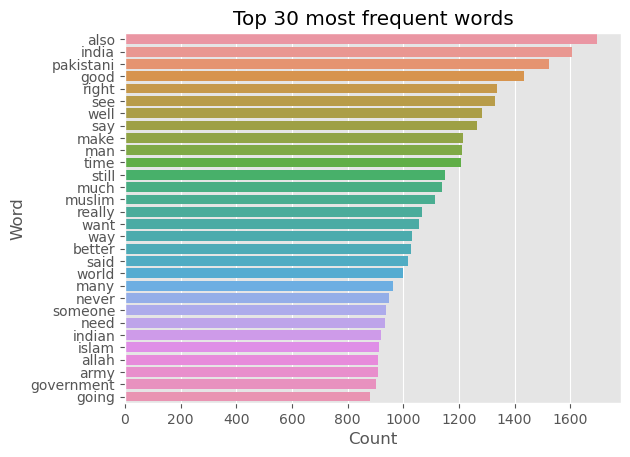

In [95]:
# Sort based on frequency of words
df_eda = df_eda.sort_values('count')
# Bar plot frequency of words 
sns.barplot(df_eda[-10:-40:-1], y='word', x='count').set(xlabel='Count', ylabel='Word', title='Top 30 most frequent words')
plt.show()

In [96]:
df_eda.query('word == "made" or word == "make"')

,word,count,word_len
181,made,704,4
121,make,1215,4


As we can see, some words like *make*, *made* are as different words. We will use lemmatization to convert them to a single word.

In [97]:
### Lemmatize the words and create a new dataframe with the lemmatized words
lemmatizer = WordNetLemmatizer()
df_lemmatized = pd.DataFrame(columns=['count', 'word_len'])
for i in df_eda.index:
    lemmatized_word = lemmatizer.lemmatize(df_eda['word'][i])
    if lemmatized_word not in df_lemmatized.index:
        df_lemmatized.loc[lemmatized_word] = [df_eda['count'][i], len(lemmatized_word)]
    else:
        df_lemmatized.loc[lemmatized_word][0] += df_eda['count'][i]
df_lemmatized.reset_index(inplace=True)
df_lemmatized.rename(columns={'index':'word'}, inplace=True)
df_lemmatized.sort_values(by='count', ascending=False, inplace=True)
df_lemmatized.head()

,word,count,word_len
8666,people,4844,6
10500,pakistan,4557,8
10499,like,4100,4
10498,one,2345,3
10497,even,2317,4


In [98]:
# Removing words with length less than 3
df_lemmatized = df_lemmatized[df_lemmatized['word'].apply(lambda x: len(x)>2)]

In [99]:
df_lemmatized.shape

(10489, 3)

#### Histogram of word frequencies with Lemmatization

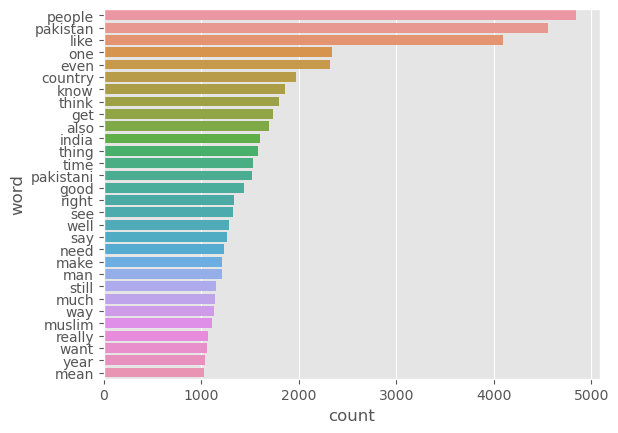

In [100]:
# Bar plot frequency of words 
sns.barplot(df_lemmatized[:30], y='word', x='count')
plt.show()

In [101]:
df_eda['word'].tolist()[::-1][:5] # list of words in decreasing order of frequency

['people', 'pakistan', 'like', 'one', 'even']

### Pairplot among upvotes, and frequency of words chosen per comment (here, most frequent 5 words)

In [102]:
# Creating copy for word cloud and pair plot
df_cleaned = df.copy()
df_cleaned = df_cleaned.reset_index()

In [103]:
tokenizer = TweetTokenizer()

df_cleaned = df_cleaned.assign(comment_token = '')
token_list = []
for i in range(df_cleaned.shape[0]):
    
    df_cleaned['comment_token'][i] = tokenizer.tokenize(df_cleaned['comment_body'][i].lower())
    

df_cleaned['comment_token'].head()


/tmp/ipykernel_38143/4008025313.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['comment_token'][i] = tokenizer.tokenize(df_cleaned['comment_body'][i].lower())


0    [good, to, see, the, boy, bringing, a, plate, ...
1    [when, i, was, about, 10, of, 12, ,, my, aunt,...
2                        [i, wanna, be, a, kid, again]
3    [is, this, not, a, cross, post, ?, am, sure, t...
4                                     [#noplastic, 👏🏽]
Name: comment_token, dtype: object

In [104]:

# words_corr = ['people', 'good', 'like', 'think', 'country'] # labelled as word_0, word_1, word_2, word_3, word_4 and so on
words_corr = df_eda['word'].tolist()[::-1][:5] # most frequent 5 words labelled as word_0, word_1, word_2, word_3, word_4


# find indexes of words_corr in df_eda['word'].tolist()[::-1]
index_list = []
for word in tqdm(words_corr):
    index_list.append(df_eda[df_eda['word']==word].index[0])
    
# create a seperate frequency column for most frequent words
for k in range(len(words_corr)):
    df_cleaned[f'word_{k}'] = [0]*df_cleaned.shape[0]

# can take 15-25 minutes to run
for i in tqdm(range(df_cleaned.shape[0])): 
    
    for j in range(len(df_cleaned['comment_token'][i])):
        for k in range(len(words_corr)):
            
            if df_cleaned['comment_token'][i][j] in df_eda['word'].tolist()[index_list[k]]:
                df_cleaned[f'word_{k}'][i] += 1
            
df_cleaned.head()

  0%|          | 0/32254 [00:00<?, ?it/s]/tmp/ipykernel_38143/1179816509.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[f'word_{k}'][i] += 1
100%|██████████| 32254/32254 [07:30<00:00, 71.65it/s] 


,index,comment_id,comment_parent_id,comment_body,comment_depth,comment_score,comment_created_utc,len,comment_token,word_0,word_1,word_2,word_3,word_4
0,0,fixj9k6,t3_facphh,Good to see the boy bringing a plate and reduc...,0,87,1.582821e+09,12,"[good, to, see, the, boy, bringing, a, plate, ...",0,1,0,1,1
1,1,fixlaf1,t3_facphh,"When I was about 10 of 12, my aunt gave me a r...",0,58,1.582822e+09,87,"[when, i, was, about, 10, of, 12, ,, my, aunt,...",7,11,0,2,9
2,2,fixjxch,t3_facphh,I wanna be a kid again,0,15,1.582822e+09,6,"[i, wanna, be, a, kid, again]",2,2,0,1,2
3,3,fixoklu,t3_facphh,Is this not a cross post? Am sure the pics sub...,0,29,1.582824e+09,46,"[is, this, not, a, cross, post, ?, am, sure, t...",1,1,0,2,4
4,4,fixgksl,t3_facphh,#noplastic 👏🏽,0,21,1.582820e+09,2,"[#noplastic, 👏🏽]",0,0,0,0,0


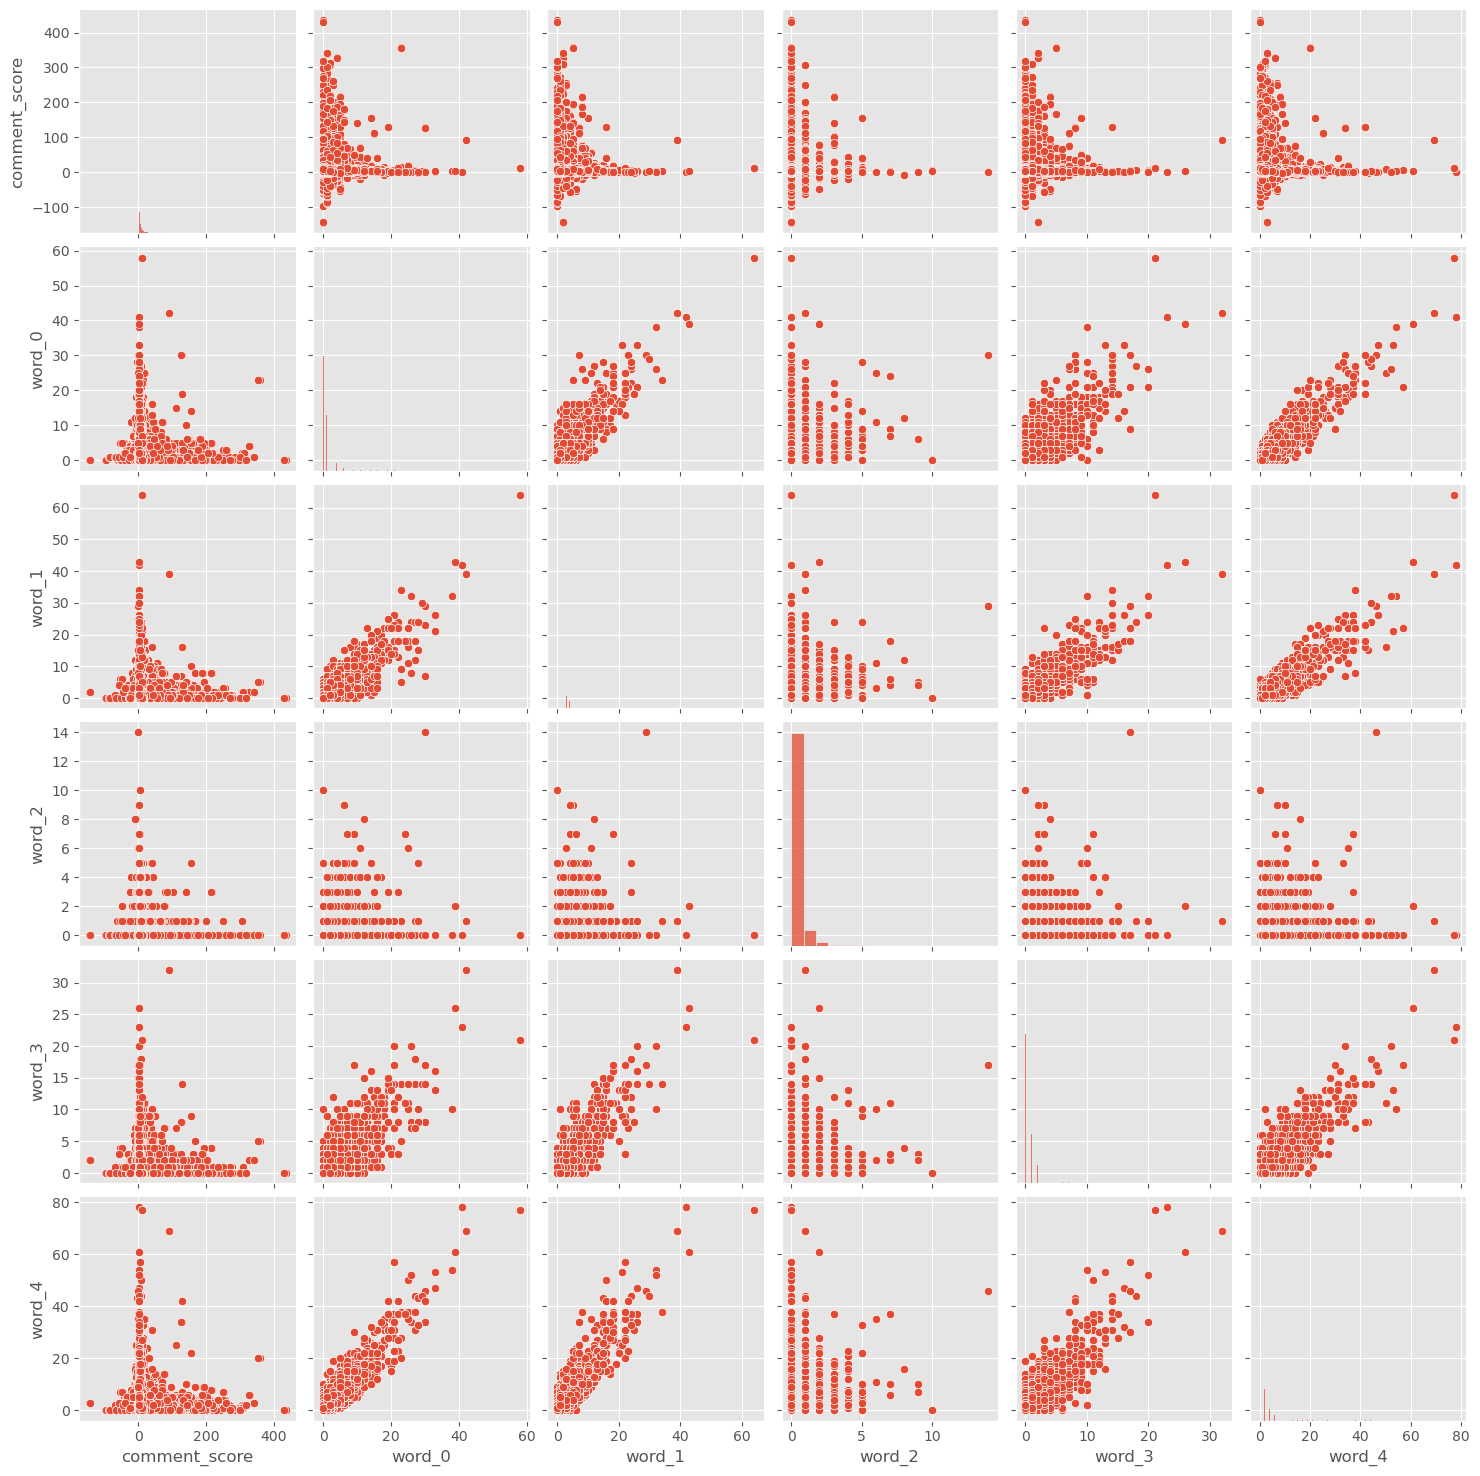

In [105]:
# do pair plot of forementioned words with upvotes
sns.pairplot(df_cleaned[['comment_score', 'word_0', 'word_1', 'word_2', 'word_3', 'word_4']]) 
plt.show()


### Observations:

* There were a lot of comments which were either [removed], [deleted] or under moderation. These were removed while preprocessing so as to do EDA.
* There were quite a number of comments with only usernames, subreddit, reddit mentions which had to be removed while preprocessing.
* There were some comments which had urls, emails which do not form part of our analysis, so we removed the urls and emails from the comments.
* There were words which had to be considered as spam due to their very long length and had to be removed while comparing them to the vocabulary present in wordnet corpus.
* The most frequent words were of a neutral to positive stance, while also consisting of nationalistic or religious words like '*india*', '*indian*', '*pakistan*', '*pakistani*', '*muslim*', '*allah*', and so on.
* From the pairplot, though we could not find any significant correlation between most frequent 5 words and upvote scores, we found some positive correlation between frequency (per comment) of some most frequent words. 

### References:

* [medium.com](https://medium.com/geekculture/data-preprocessing-and-eda-for-natural-language-processing-56e45c1df36d)  
